# Case Study - Subscription for Bank Deposits 

In this notebook, our objective is to understand data and apply data processing appropriately.

Author: Furkan Cantürk / 01.11.2021
    
Some parts of the code taken from this notebook: https://github.com/sayandesarkar/sliderule/blob/master/Capstone_Project/capstone_project.ipynb

### General Information on the Data

**Overview**: The data is related to the direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

This dataset is based on "Bank Marketing" UCI dataset (http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The data are enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb. The binary classification goal is to predict if the client will subscribe a bank term deposit (variable y).

**Number of Instances**: 41,188

**Number of Attributes**: 20+ output attributes

﻿Citation Request:
  This dataset is publicly available for research. The details are described in [Moro et al., 2014]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

 ## Feature Information

   ### Client information
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   
   ### Features related with the last contact of the current campaign
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
   ### Other features related to the previous campaign
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
   ### Social and economic context features
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  ### Output variable (desired target)
  21 - y : Has the client subscribed to a term deposit? (binary: "yes","no")

  ### Missing Attribute Values
  There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

try:
    from imblearn.over_sampling import SMOTE, ADASYN
except:
    !pip install imblearn
    from imblearn.over_sampling import SMOTE, ADASYN

#setting the seed number for code reproducibility
np.random.seed(42)
random.seed(42)

#Changing default display option to display more columns
pd.options.display.max_columns = 50
#pd.options.display.max_rows  = 50
pd.set_option("display.max_rows", 50)

### Loading the dataset

In [6]:
df = pd.read_csv('data.csv', sep=';')
df.shape

(41188, 21)

In [7]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
9403,36,admin.,married,high.school,no,no,no,telephone,jun,fri,355,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
14020,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,189,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
17201,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,605,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
879,48,services,married,high.school,unknown,yes,no,telephone,may,wed,243,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
23757,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,24,7,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
10821,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,126,4,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
14355,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,43,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
#Dropping the duplicate rows if exists
df.drop_duplicates(inplace=True)

df.shape

(41176, 21)

In [10]:
#Selecting categorical columns
#categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
target = 'y'
categorical = df.dtypes[df.dtypes == 'object'].index.tolist()
categorical.remove(target)
numerical = df.dtypes[df.dtypes != 'object'].index.tolist()

#Looping through the columns and changing type to 'category'
for column in categorical:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  int64   
 1   job             41176 non-null  category
 2   marital         41176 non-null  category
 3   education       41176 non-null  category
 4   default         41176 non-null  category
 5   housing         41176 non-null  category
 6   loan            41176 non-null  category
 7   contact         41176 non-null  category
 8   month           41176 non-null  category
 9   day_of_week     41176 non-null  category
 10  duration        41176 non-null  int64   
 11  campaign        41176 non-null  int64   
 12  pdays           41176 non-null  int64   
 13  previous        41176 non-null  int64   
 14  poutcome        41176 non-null  category
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

### Categorical Features

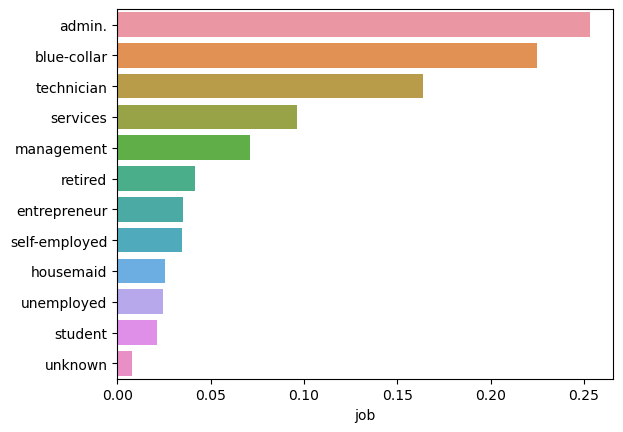

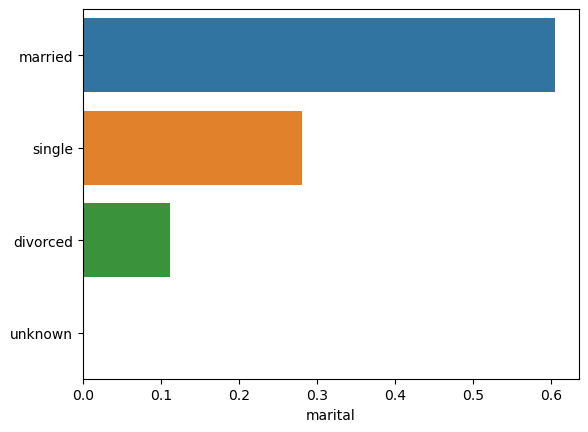

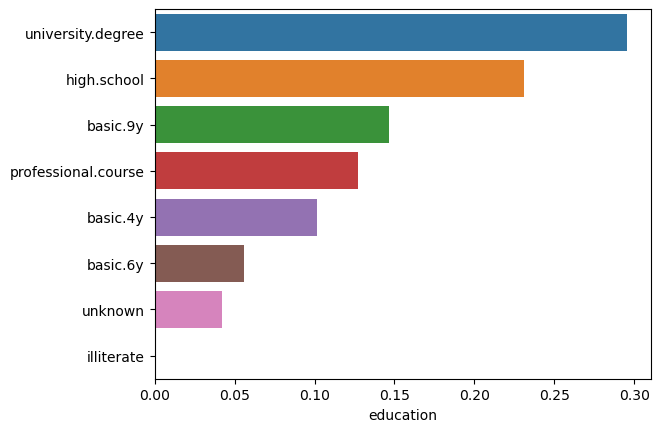

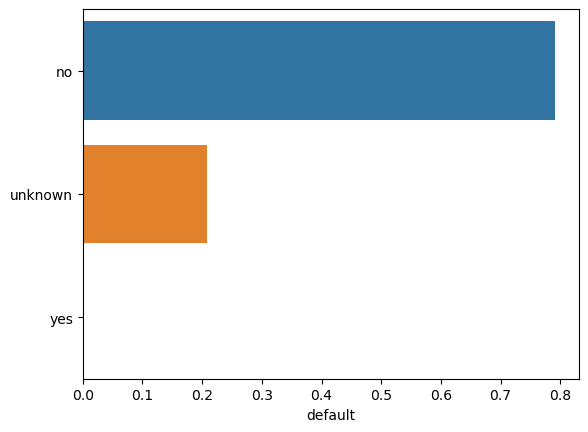

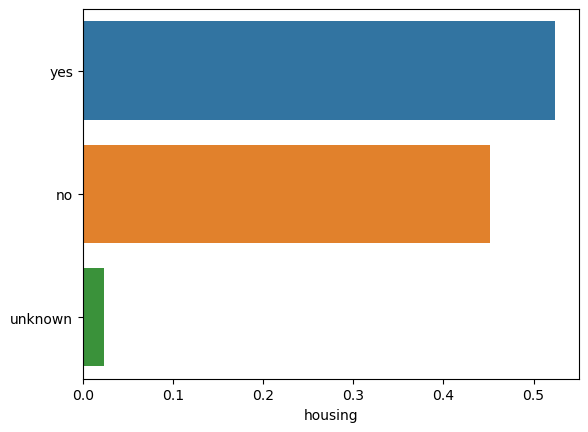

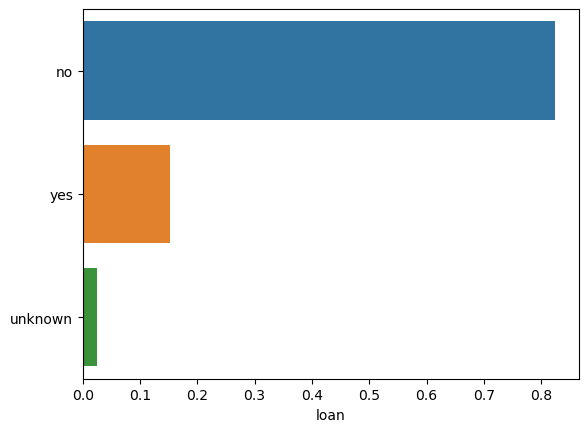

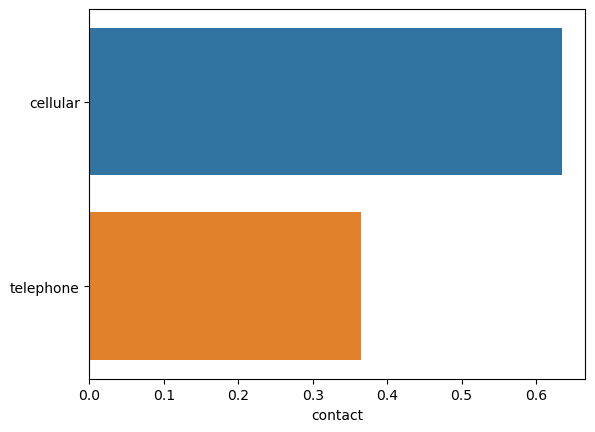

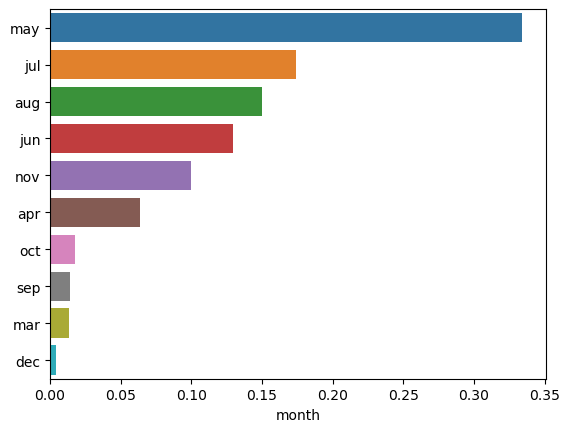

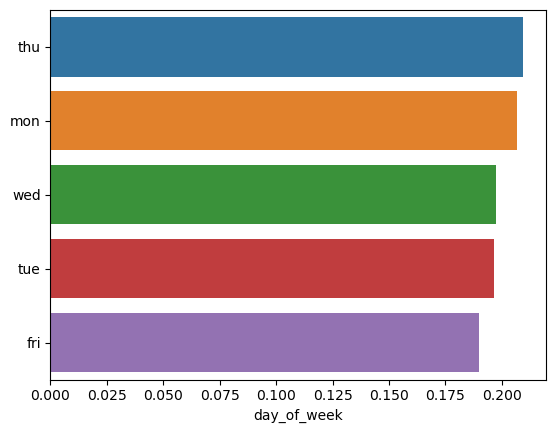

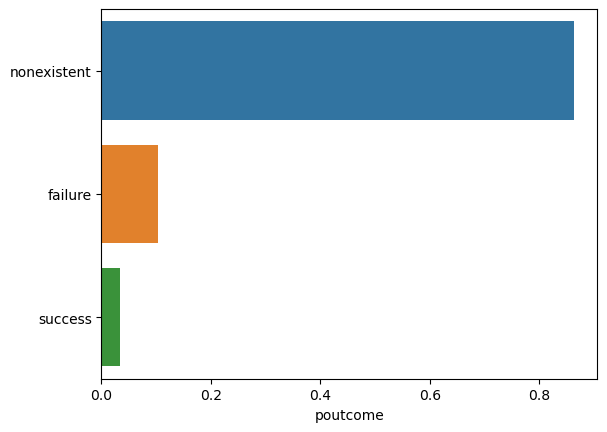

In [11]:
#Bar plots of categorical features
for feature in categorical:
    value_percentages = df[feature].value_counts(normalize=True, sort=True)
    sns.barplot(x=value_percentages, y=value_percentages.index, orient='h', order=value_percentages.index)
    plt.show()

### Numerical Features

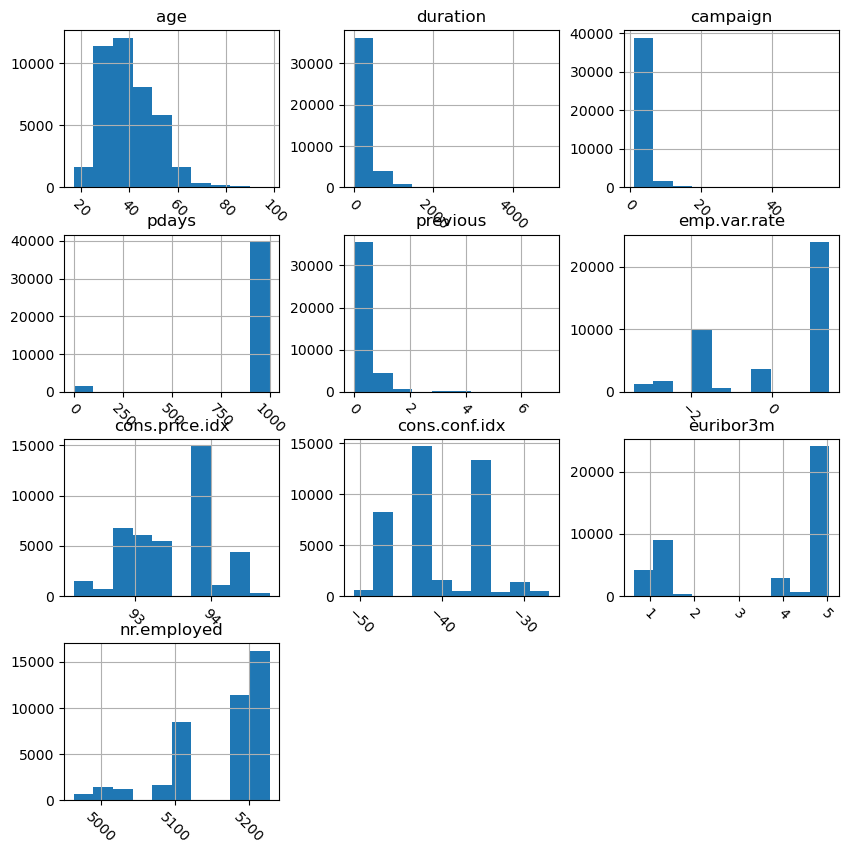

In [12]:
# Histogram grid
df.hist(figsize=(10,10), xrot=-45)

# Clear the text "residue"
plt.show()


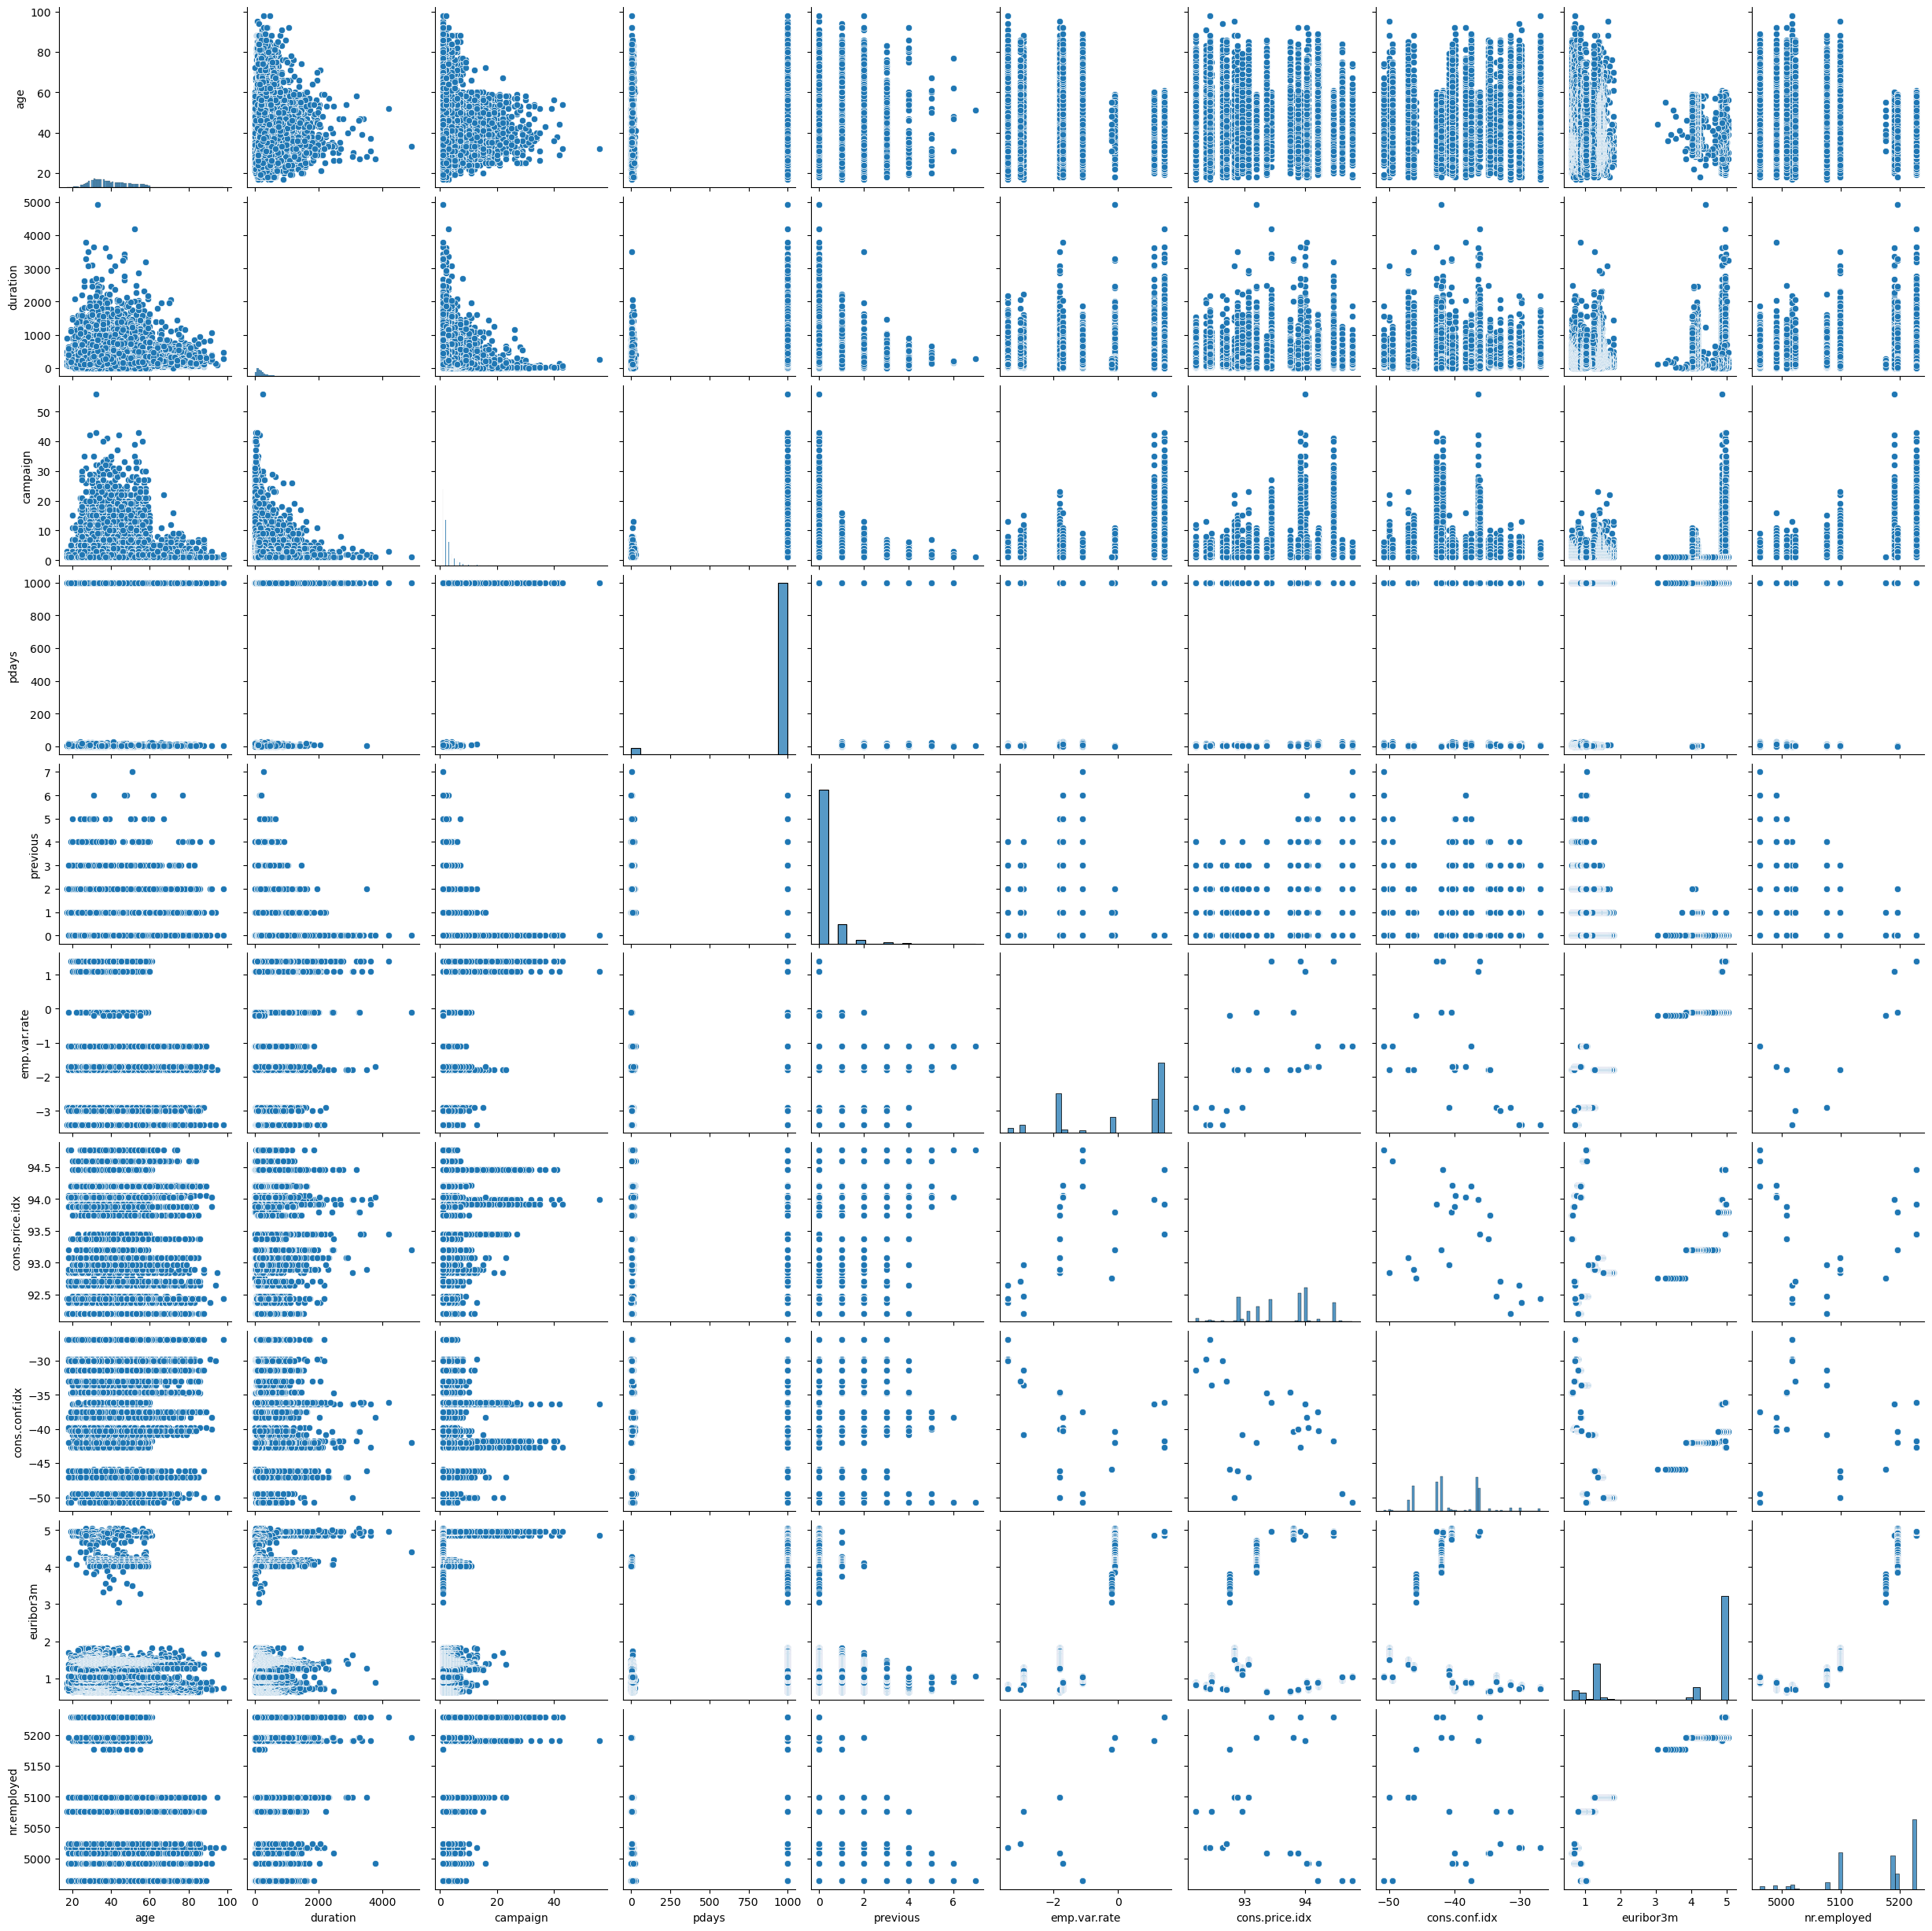

In [13]:
sns.pairplot(df)

In [14]:
#Summary of numeric features
df.describe()#.round(1)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Target (Dependent) Variable

no     0.887337
yes    0.112663
Name: y, dtype: float64


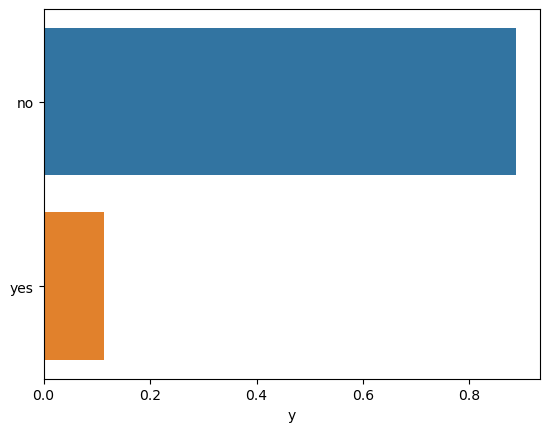

In [15]:
class_percentages = df[target].value_counts(normalize=True)
print(class_percentages)
sns.barplot(x=class_percentages, y=class_percentages.index, orient='h')
plt.show()

# Data Preprocessing

In [16]:
#Copy the original dataframe before changing operations
clean_df = df.copy()

In [17]:
#Replacing 'yes', 'no', and 'unknown' values with 1, 0, and NaN respectively to obtain numerical features
#Using NaN value allows using Pandas & Numpy operations (e.g. mean, std, describe, isna, and value_counts ...)
#which can ignore or select rows with NaN values

clean_df.y = clean_df.y.map({'yes': 1, 'no': 0})
clean_df.default = clean_df.default.map({'yes': 1, 'no': 0, 'unknown': np.nan})
clean_df.loan = clean_df.loan.map({'yes': 1, 'no': 0, 'unknown': np.nan})
clean_df.housing = clean_df.housing.map({'yes': 1, 'no': 0, 'unknown': np.nan})
clean_df.job.replace(to_replace ='unknown', value=np.nan, inplace=True)
clean_df.marital.replace(to_replace='unknown', value=np.nan, inplace=True)
clean_df.education.replace(to_replace='unknown', value=np.nan, inplace=True)
clean_df.pdays.replace(to_replace=999, value=np.nan, inplace=True) #999 means client was not previously contacted

In [18]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         32580 non-null  float64 
 5   housing         40186 non-null  float64 
 6   loan            40186 non-null  float64 
 7   contact         41176 non-null  category
 8   month           41176 non-null  category
 9   day_of_week     41176 non-null  category
 10  duration        41176 non-null  int64   
 11  campaign        41176 non-null  int64   
 12  pdays           1515 non-null   float64 
 13  previous        41176 non-null  int64   
 14  poutcome        41176 non-null  category
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

In [19]:
# number of null values for each variable
clean_df.isna().sum(axis=0)

age                   0
job                 330
marital              80
education          1730
default            8596
housing             990
loan                990
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays             39661
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

In [20]:
df[categorical].nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [21]:
# You can consider to merge values of categorical features which have a similar meaning into a single value, 
# especially for the values which are minority.
# So, you can reduce the cardinality of data. (Recall the Curse of Dimensionality!!!)
# But, you should also check the distribution of the feature levels according to the target (dependent) variable.

#The following operations might be meaningful, but they cause information loss. Thus, further inspection should be done.

if False:
    #Combining entrepreneurs and self-employed into self-employed
    clean_df.job.replace(['entrepreneur', 'self-employed'], 'self-employed', inplace=True)

    #Combining administrative and management jobs into admin_management
    clean_df.job.replace(['admin.', 'management'], 'administration_management', inplace=True)

    #Combining blue-collar and tecnician jobs into blue-collar
    clean_df.job.replace(['blue-collar', 'technician'], 'blue-collar', inplace=True)

    #Combining retired and unemployed into no_active_income
    clean_df.job.replace(['retired', 'unemployed', 'student'], 'no_active_income', inplace=True)

    #Combining services and housemaid into services
    clean_df.job.replace(['services', 'housemaid'], 'services', inplace=True)

    #Combining single and divorced into single
    clean_df.marital.replace(['single', 'divorced'], 'single', inplace=True)

    #Combining basic school degrees
    clean_df.education.replace(['basic.9y', 'basic.6y', 'basic.4y'], 'basic_school', inplace=True)

### 

In [22]:
# Şu üç durum sağlanırsa bir kategorik değişkenin kategorileri, üst bir kategoride birleştirebilir.
# 1) kategoriler anlamsal olarak birbirine yakınsa
# 2) kategorilerin hedef değişken ile olan ilişkileri benzer ise (örneğin lineer ilişki için pozitiflik oranı)
# 3) verinin çoğunluğunu temsil eden kategoriler değilse

In [23]:
target_by_jobs = clean_df.groupby(['job', 'y']).size().unstack()
target_by_jobs

y,0,1
job,,
admin.,9068,1351
blue-collar,8615,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1284,434
self-employed,1272,149
services,3644,323
student,600,275


In [24]:
target_by_jobs['count'] = target_by_jobs.sum(axis=1)
target_by_jobs['pos_rate'] = target_by_jobs[1] / target_by_jobs['count']
target_by_jobs.sort_values('count', ascending=False).round(2)

y,0,1,count,pos_rate
job,,,,
admin.,9068,1351,10419,0.13
blue-collar,8615,638,9253,0.07
technician,6009,730,6739,0.11
services,3644,323,3967,0.08
management,2596,328,2924,0.11
retired,1284,434,1718,0.25
entrepreneur,1332,124,1456,0.09
self-employed,1272,149,1421,0.10
housemaid,954,106,1060,0.10


In [25]:
target_by_mar  = clean_df.groupby(['marital', 'y']).size().unstack()
target_by_mar['count'] = target_by_mar.sum(axis=1)
target_by_mar['pos_rate'] = target_by_mar[1] / target_by_mar['count']
target_by_mar.sort_values('pos_rate', ascending=False).round(2)

y,0,1,count,pos_rate
marital,,,,
single,9944,1620,11564,0.14
divorced,4135,476,4611,0.10
married,22390,2531,24921,0.10


In [26]:
target_by_edu  = clean_df.groupby(['education', 'y']).size().unstack()
target_by_edu['count'] = target_by_edu.sum(axis=1)
target_by_edu['pos_rate'] = target_by_edu[1] / target_by_edu['count']
target_by_edu.sort_values('pos_rate', ascending=False).round(2)

y,0,1,count,pos_rate
education,,,,
illiterate,14,4,18,0.22
university.degree,10495,1669,12164,0.14
professional.course,4645,595,5240,0.11
high.school,8481,1031,9512,0.11
basic.4y,3748,428,4176,0.10
basic.6y,2103,188,2291,0.08
basic.9y,5572,473,6045,0.08


In [27]:
#The following replacements seems reasonable according to the class weights (positive rates) and the portion levels depicted above.

clean_df.job.replace(['entrepreneur', 'self-employed'], 'self-employed', inplace=True)
clean_df.education.replace(['basic.9y', 'basic.6y', 'basic.4y'], 'basic_school', inplace=True)

#It is worth to note that effectiveness of such cardinality reduction operations
#for a learning task should be tested over different versions of the dataset.
#(i.e. train your models over different configurations of data)

## Handling with Missing Values (Dropping & Imputation)

In [28]:
cols_with_null = list(clean_df.columns[clean_df.isna().sum() > 0])
cols_with_null

['job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays']

In [29]:
clean_df[cols_with_null].isna().sum()

job            330
marital         80
education     1730
default       8596
housing        990
loan           990
pdays        39661
dtype: int64

In [30]:
clean_df[cols_with_null][clean_df[cols_with_null].isna().any(axis=1)]

,job,marital,education,default,housing,loan,pdays
0,housemaid,married,basic_school,0.0,0.0,0.0,NaN
1,services,married,high.school,NaN,0.0,0.0,NaN
2,services,married,high.school,0.0,1.0,0.0,NaN
3,admin.,married,basic_school,0.0,0.0,0.0,NaN
4,services,married,high.school,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...
41183,retired,married,professional.course,0.0,1.0,0.0,NaN
41184,blue-collar,married,professional.course,0.0,0.0,0.0,NaN
41185,retired,married,university.degree,0.0,1.0,0.0,NaN
41186,technician,married,professional.course,0.0,0.0,0.0,NaN


In [31]:
#Some instances have null values for default, loan and housing at the same time.

rows_with_multiple_nan_values = clean_df[(clean_df.default.isna()) & (clean_df.loan.isna()) & (clean_df.housing.isna())]
rows_with_multiple_nan_values

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29,55,NaN,married,university.degree,NaN,NaN,NaN,telephone,may,mon,362,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
81,51,blue-collar,married,basic_school,NaN,NaN,NaN,telephone,may,mon,212,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
385,59,management,married,basic_school,NaN,NaN,NaN,telephone,may,tue,437,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
401,48,services,married,high.school,NaN,NaN,NaN,telephone,may,tue,152,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
470,42,technician,single,professional.course,NaN,NaN,NaN,telephone,may,tue,529,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34618,33,blue-collar,married,basic_school,NaN,NaN,NaN,cellular,may,thu,551,2,NaN,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,0
34826,59,management,married,basic_school,NaN,NaN,NaN,cellular,may,thu,165,4,NaN,1,failure,-1.8,92.893,-46.2,1.266,5099.1,0
34970,42,self-employed,married,professional.course,NaN,NaN,NaN,cellular,may,fri,665,1,NaN,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,0
37661,71,retired,married,basic_school,NaN,NaN,NaN,cellular,aug,tue,216,1,NaN,0,nonexistent,-2.9,92.201,-31.4,0.859,5076.2,1


In [32]:
#Dropping the rows with multiple NaN values

clean_df = clean_df.drop(rows_with_multiple_nan_values.index, axis=0)
reduction_rate = round(1 - clean_df.shape[0]/df.shape[0], 4)
print("Dataset is reduced by", reduction_rate, '% after dropping.')

Dataset is reduced by 0.0055 % after dropping.


In [33]:
clean_df[cols_with_null].isna().sum()

job            326
marital         80
education     1712
default       8369
housing        763
loan           763
pdays        39435
dtype: int64

In [34]:
#Dropping the unknown job level
clean_df = clean_df[~clean_df.job.isna()]

#Dropping the unknown marital status
clean_df = clean_df[~clean_df.marital.isna()]

#clean_df.reset_index(inplace=True, drop=True)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40552 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             40552 non-null  int64   
 1   job             40552 non-null  category
 2   marital         40552 non-null  category
 3   education       38973 non-null  category
 4   default         32340 non-null  float64 
 5   housing         39791 non-null  float64 
 6   loan            39791 non-null  float64 
 7   contact         40552 non-null  category
 8   month           40552 non-null  category
 9   day_of_week     40552 non-null  category
 10  duration        40552 non-null  int64   
 11  campaign        40552 non-null  int64   
 12  pdays           1489 non-null   float64 
 13  previous        40552 non-null  int64   
 14  poutcome        40552 non-null  category
 15  emp.var.rate    40552 non-null  float64 
 16  cons.price.idx  40552 non-null  float64 
 17  cons.conf.id

In [35]:
clean_df[cols_with_null].isna().sum()

job              0
marital          0
education     1579
default       8212
housing        761
loan           761
pdays        39063
dtype: int64

In [36]:
#Most of the data have null value for pdays.
#Dropping such number of instances would reduce the dataset extremely.
#Thus, imputation should be tried in first place.

#pdays, previous, and poutcome are the features that provide related information with each other about the previous campaign.
#So, comparing the value counts of these features might provide a useful information for the imputation for null values of pdays. 

#pdays: number of days that passed by after the client was last contacted from a previous campaign 
#previous: number of contacts performed before this campaign and for this client (numeric)
#poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")

In [37]:
clean_df.poutcome.value_counts(dropna=False)

nonexistent    34995
failure         4209
success         1348
Name: poutcome, dtype: int64

In [38]:
clean_df.previous.value_counts(dropna=False)

0    34995
1     4510
2      740
3      213
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [39]:
clean_df.pdays.value_counts(dropna=False)

NaN     39063
3.0       431
6.0       403
4.0       116
9.0        64
7.0        60
2.0        59
12.0       58
10.0       52
5.0        46
13.0       35
11.0       27
1.0        25
15.0       24
14.0       20
8.0        17
0.0        15
16.0       10
17.0        8
18.0        7
22.0        3
19.0        3
21.0        2
25.0        1
26.0        1
27.0        1
20.0        1
Name: pdays, dtype: int64

In [40]:
# There are 34995 clients which did not exist during the previous campaign.
# So, their number of campaign contacts (previous) is zero naturally.
# But, there are 39063 null values in pdays, which is higher than 34955. 
# We can accept pdays = NaN for 34995 clients whose poutcome is 'nonexistent', but for the rest 4068 clients, pdays should not be NaN.
# Thus, consider these extra null values of pdays as mistaken data.

In [41]:
#getting the indices of data in which pdays are NaN and poutcome is not 'nonexistent'
rows_with_mismatch_pdays = clean_df[(clean_df.poutcome != 'nonexistent') & (clean_df.pdays.isna())]
rows_with_mismatch_pdays

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24013,38,blue-collar,single,NaN,0.0,1.0,0.0,telephone,oct,tue,39,1,NaN,1,failure,-0.1,93.798,-40.4,4.968,5195.8,0
24019,40,services,married,high.school,0.0,1.0,0.0,telephone,oct,tue,144,1,NaN,1,failure,-0.1,93.798,-40.4,4.968,5195.8,1
24076,36,admin.,married,university.degree,0.0,1.0,0.0,telephone,nov,wed,449,1,NaN,1,failure,-0.1,93.200,-42.0,4.663,5195.8,0
24102,36,admin.,married,high.school,0.0,1.0,0.0,telephone,nov,wed,114,1,NaN,1,failure,-0.1,93.200,-42.0,4.286,5195.8,1
24113,29,self-employed,married,university.degree,0.0,1.0,0.0,telephone,nov,thu,86,1,NaN,1,failure,-0.1,93.200,-42.0,4.245,5195.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41166,32,admin.,married,university.degree,0.0,0.0,0.0,telephone,nov,wed,651,1,NaN,1,failure,-1.1,94.767,-50.8,1.030,4963.6,1
41170,40,management,divorced,university.degree,0.0,1.0,0.0,cellular,nov,wed,293,2,NaN,4,failure,-1.1,94.767,-50.8,1.030,4963.6,0
41173,62,retired,married,university.degree,0.0,1.0,0.0,cellular,nov,thu,329,1,NaN,2,failure,-1.1,94.767,-50.8,1.031,4963.6,1
41175,34,student,single,NaN,0.0,1.0,0.0,cellular,nov,thu,180,1,NaN,2,failure,-1.1,94.767,-50.8,1.031,4963.6,0


In [42]:
#Mean pdays values of the data groups which are separated according to 'poutcome' and 'previous'. 

mean_pdays = clean_df.groupby(['poutcome', 'previous'])['pdays'].mean().unstack()
mean_pdays

previous,0,1,2,3,4,5,6,7
poutcome,,,,,,,,
failure,NaN,NaN,10.423529,9.513514,9.611111,21.0,NaN,NaN
nonexistent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success,NaN,6.06338,4.980645,4.738095,4.250000,3.4,2.5,3.0


In [43]:
#Let's impute rows_with_mismatch_pdays with mean pdays values ofthe rows which have same poutcome and previous values.

clean_df.loc[rows_with_mismatch_pdays.index, 'pdays'] = rows_with_mismatch_pdays.apply(lambda x: mean_pdays.loc[x['poutcome'], x['previous']].round(1), axis=1)

clean_df.loc[rows_with_mismatch_pdays.index]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24013,38,blue-collar,single,NaN,0.0,1.0,0.0,telephone,oct,tue,39,1,NaN,1,failure,-0.1,93.798,-40.4,4.968,5195.8,0
24019,40,services,married,high.school,0.0,1.0,0.0,telephone,oct,tue,144,1,NaN,1,failure,-0.1,93.798,-40.4,4.968,5195.8,1
24076,36,admin.,married,university.degree,0.0,1.0,0.0,telephone,nov,wed,449,1,NaN,1,failure,-0.1,93.200,-42.0,4.663,5195.8,0
24102,36,admin.,married,high.school,0.0,1.0,0.0,telephone,nov,wed,114,1,NaN,1,failure,-0.1,93.200,-42.0,4.286,5195.8,1
24113,29,self-employed,married,university.degree,0.0,1.0,0.0,telephone,nov,thu,86,1,NaN,1,failure,-0.1,93.200,-42.0,4.245,5195.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41166,32,admin.,married,university.degree,0.0,0.0,0.0,telephone,nov,wed,651,1,NaN,1,failure,-1.1,94.767,-50.8,1.030,4963.6,1
41170,40,management,divorced,university.degree,0.0,1.0,0.0,cellular,nov,wed,293,2,9.6,4,failure,-1.1,94.767,-50.8,1.030,4963.6,0
41173,62,retired,married,university.degree,0.0,1.0,0.0,cellular,nov,thu,329,1,10.4,2,failure,-1.1,94.767,-50.8,1.031,4963.6,1
41175,34,student,single,NaN,0.0,1.0,0.0,cellular,nov,thu,180,1,10.4,2,failure,-1.1,94.767,-50.8,1.031,4963.6,0


In [44]:
clean_df.isna().sum().sort_values(ascending=False).head(10)

pdays            38654
default           8212
education         1579
housing            761
loan               761
age                  0
previous             0
nr.employed          0
euribor3m            0
cons.conf.idx        0
dtype: int64

In [45]:
# Most of the data has still null values for pdays
print(clean_df.pdays.isna().sum() / clean_df.shape[0])

0.9531958966265536


In [46]:
# You can consider three operations to eliminate the effect of null values in pdays:
# 1. Imputation with the mean value of pdays: Since 5% of data has a non-null value for pdays, using a statistical information is impractical. 
# 2. Drop pdays feature from the data: A good and easy way to go, but it means information loss.
# 3. Generate a new feature: pdays can be used to represent the information of whether a client is new after the previous campaign.

In [47]:
clean_df.shape

(40552, 21)

In [48]:
clean_df.pdays.isna().sum()

38654

In [49]:
clean_df[clean_df.previous == 0]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic_school,0.0,0.0,0.0,telephone,may,mon,261,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,0.0,0.0,telephone,may,mon,149,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0.0,1.0,0.0,telephone,may,mon,226,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic_school,0.0,0.0,0.0,telephone,may,mon,151,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0.0,0.0,1.0,telephone,may,mon,307,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,0.0,1.0,0.0,cellular,nov,fri,281,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41183,73,retired,married,professional.course,0.0,1.0,0.0,cellular,nov,fri,334,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,0.0,0.0,0.0,cellular,nov,fri,383,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,0.0,1.0,0.0,cellular,nov,fri,189,2,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [50]:
clean_df[(clean_df.pdays.isna()) & (clean_df.previous == 0)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic_school,0.0,0.0,0.0,telephone,may,mon,261,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,0.0,0.0,telephone,may,mon,149,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0.0,1.0,0.0,telephone,may,mon,226,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic_school,0.0,0.0,0.0,telephone,may,mon,151,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0.0,0.0,1.0,telephone,may,mon,307,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,0.0,1.0,0.0,cellular,nov,fri,281,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41183,73,retired,married,professional.course,0.0,1.0,0.0,cellular,nov,fri,334,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,0.0,0.0,0.0,cellular,nov,fri,383,1,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,0.0,1.0,0.0,cellular,nov,fri,189,2,NaN,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [51]:
clean_df['is_new'] = (clean_df.pdays.isna()).astype(int)
clean_df.drop('pdays', axis=1, inplace=True)

In [52]:
clean_df.isna().sum().sort_values(ascending=False).head(10)

default          8212
education        1579
housing           761
loan              761
age                 0
poutcome            0
y                   0
nr.employed         0
euribor3m           0
cons.conf.idx       0
dtype: int64

In [53]:
#Replacing the null values in education with 'unknown' value

clean_df.education = clean_df.education.cat.add_categories('unknown')
clean_df.education.fillna('unknown', inplace= True)

In [54]:
# Homework:
# Create 10 age ranges (with equal lengths)
# Instead replacing the null values in education with 'unknown', replace them based on mode (most frequent) education level value of each age range.

In [55]:
rates = clean_df[['loan', 'housing', 'default']].mean()
print(rates)

# Replacing the null values in 'loan', 'housing', and 'default' with the mean values respectively.

# clean_df[['loan', 'housing', 'default']] = clean_df[['loan', 'housing', 'default']].fillna(rates)

# Previously, 'loan', 'housing', and 'default' had only binary values.
# This update makes the type of these features "continuous", but their values are still between 0 and 1.

# Instead, the following is a more advanced way to go

loan       0.155387
housing    0.537081
default    0.000093
dtype: float64


In [56]:
# 'loan', 'housing', and 'default' are variables that might depend on education level

# Getting the rates for 'loan', 'housing', and 'default' for each education level 
rates_by_education = clean_df.groupby(['education'])[['loan', 'housing', 'default']].mean().unstack()
rates_by_education

         education          
loan     basic_school           0.150485
         high.school            0.155070
         illiterate             0.166667
         professional.course    0.154993
         university.degree      0.162309
         unknown                0.143866
housing  basic_school           0.527734
         high.school            0.530570
         illiterate             0.555556
         professional.course    0.554836
         university.degree      0.547262
         unknown                0.512524
default  basic_school           0.000000
         high.school            0.000127
         illiterate             0.000000
         professional.course    0.000452
         university.degree      0.000000
         unknown                0.000000
dtype: float64

In [57]:
# replacing null values 'loan', 'housing', and 'default' variables with rates_by_education
for col in ['loan', 'housing', 'default']:
    clean_df.loc[clean_df[col].isna(), col] = clean_df[clean_df[col].isna()].apply(lambda row: rates_by_education[col][row['education']], axis=1)

### Observing Correlations

In [58]:
#Correlations between numeric features
corr = clean_df.corr()

corr.round(2)

C:\Users\serda\AppData\Local\Temp\ipykernel_9996\3732578331.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = clean_df.corr()


,age,default,housing,loan,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_new
age,1.00,0.00,-0.00,-0.01,0.00,0.00,0.02,-0.00,-0.00,0.13,0.01,-0.02,0.03,-0.04
default,0.00,1.00,-0.00,-0.00,-0.01,-0.00,0.00,0.01,-0.00,0.00,0.01,0.01,-0.00,0.00
housing,-0.00,-0.00,1.00,0.05,-0.01,-0.01,0.02,-0.06,-0.08,-0.03,-0.06,-0.05,0.01,-0.01
loan,-0.01,-0.00,0.05,1.00,0.00,0.00,-0.00,0.00,-0.00,-0.01,0.00,0.00,-0.00,0.00
duration,0.00,-0.01,-0.01,0.00,1.00,-0.07,0.02,-0.03,0.01,-0.01,-0.03,-0.04,0.41,-0.04
campaign,0.00,-0.00,-0.01,0.00,-0.07,1.00,-0.08,0.15,0.13,-0.01,0.14,0.14,-0.07,0.06
previous,0.02,0.00,0.02,-0.00,0.02,-0.08,1.00,-0.42,-0.20,-0.05,-0.45,-0.50,0.23,-0.72
emp.var.rate,-0.00,0.01,-0.06,0.00,-0.03,0.15,-0.42,1.00,0.78,0.20,0.97,0.91,-0.30,0.30
cons.price.idx,-0.00,-0.00,-0.08,-0.00,0.01,0.13,-0.20,0.78,1.00,0.06,0.69,0.52,-0.14,0.09
cons.conf.idx,0.13,0.00,-0.03,-0.01,-0.01,-0.01,-0.05,0.20,0.06,1.00,0.28,0.10,0.05,-0.09


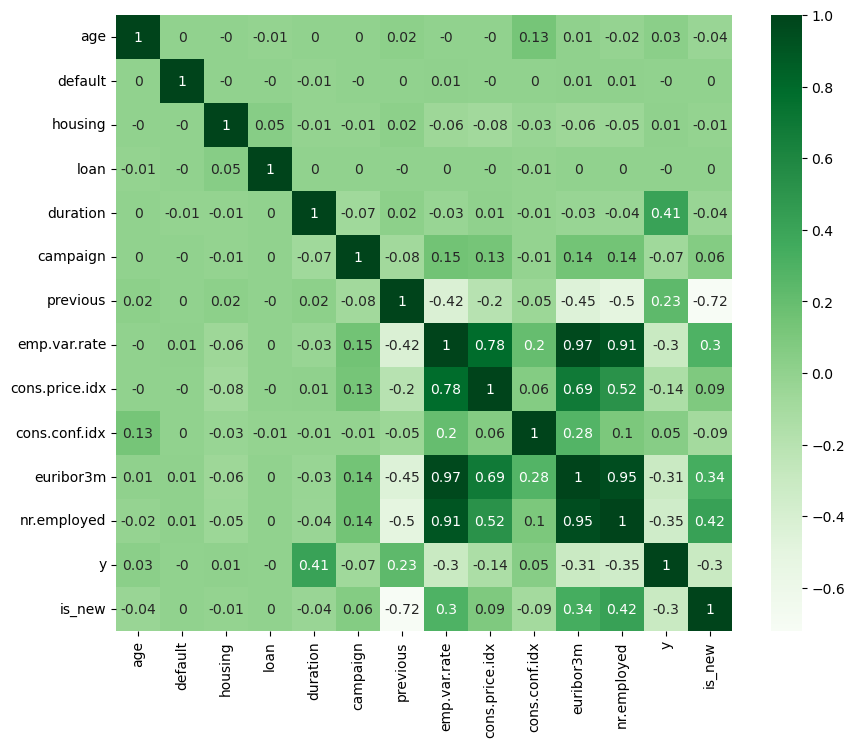

In [59]:
plt.figure(figsize=(10,8))
_ = sns.heatmap(corr.round(2), cmap="Greens",  cbar=True, annot=True, square=True)

In [60]:
#The new feature 'is_new' has a good correlation with the target variable

In [61]:
print("Correlation with the target variable")
corr.y.abs().sort_values(ascending=False)[1:]

Correlation with the target variable


duration          0.405273
nr.employed       0.354572
euribor3m         0.307490
is_new            0.302601
emp.var.rate      0.297889
previous          0.228784
cons.price.idx    0.135251
campaign          0.066625
cons.conf.idx     0.054593
age               0.030788
housing           0.011623
loan              0.004138
default           0.003383
Name: y, dtype: float64

In [62]:
# In the following cells, features having correlation >= 0.75 are filtered.

threshold = 0.75

In [63]:
corr_stack = corr.stack()
corr_stack

age     age              1.000000
        default          0.002452
        housing         -0.001618
        loan            -0.006541
        duration         0.000457
                           ...   
is_new  cons.conf.idx   -0.085953
        euribor3m        0.335216
        nr.employed      0.417036
        y               -0.302601
        is_new           1.000000
Length: 196, dtype: float64

In [64]:
corr_stack = corr_stack.loc[[tup for tup in corr_stack.index if tup[0] != tup[1]]] # dropping pairs of itself
high_corr = corr_stack[(abs(corr_stack) > threshold)]
high_corr

emp.var.rate    cons.price.idx    0.775051
                euribor3m         0.972165
                nr.employed       0.906697
cons.price.idx  emp.var.rate      0.775051
euribor3m       emp.var.rate      0.972165
                nr.employed       0.945170
nr.employed     emp.var.rate      0.906697
                euribor3m         0.945170
dtype: float64

In [65]:
high_corr = high_corr.unstack()
high_corr.round(2)

,cons.price.idx,euribor3m,nr.employed,emp.var.rate
emp.var.rate,0.78,0.97,0.91,NaN
cons.price.idx,NaN,NaN,NaN,0.78
euribor3m,NaN,NaN,0.95,0.97
nr.employed,NaN,0.95,NaN,0.91


In [66]:
high_corr['mean'] = high_corr.mean(axis=1)
high_corr.round(2)

,cons.price.idx,euribor3m,nr.employed,emp.var.rate,mean
emp.var.rate,0.78,0.97,0.91,NaN,0.88
cons.price.idx,NaN,NaN,NaN,0.78,0.78
euribor3m,NaN,NaN,0.95,0.97,0.96
nr.employed,NaN,0.95,NaN,0.91,0.93


In [67]:
print("Correlation with the target variable")
corr.y.abs().sort_values(ascending=False)[1:]

Correlation with the target variable


duration          0.405273
nr.employed       0.354572
euribor3m         0.307490
is_new            0.302601
emp.var.rate      0.297889
previous          0.228784
cons.price.idx    0.135251
campaign          0.066625
cons.conf.idx     0.054593
age               0.030788
housing           0.011623
loan              0.004138
default           0.003383
Name: y, dtype: float64

In [68]:
# nr.employed, euribor3m, and emp.var.rate are highly correlated with each other.
# But, they have also high correlation with the target, where nr.employed has the highest correlation with the target variable
# So, nr.employed should be kept and 'emp.var.rate' and 'euribor3m' are dropped from the dataset.
# cons.price.idx can be kept as well since 'emp.var.rate' and 'euribor3m' are dropped.
cols_to_drop = ['emp.var.rate', 'euribor3m']

### Data Splitting and Standardization

In [69]:
X = pd.get_dummies(clean_df.drop(cols_to_drop + ['y'], axis=1), drop_first=True)
y = clean_df.y

In [70]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Fitting Logistic Regression

In [71]:
lr1 = LogisticRegression(random_state=42, n_jobs=-1)
lr1.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [72]:
pred_train = lr1.predict(X_train)
pred_test = lr1.predict(X_test)

#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_train))

print("TEST")
print(classification_report(y_test, pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     25207
           1       0.67      0.41      0.50      3179

    accuracy                           0.91     28386
   macro avg       0.80      0.69      0.73     28386
weighted avg       0.90      0.91      0.90     28386

TEST
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10763
           1       0.66      0.41      0.51      1403

    accuracy                           0.91     12166
   macro avg       0.79      0.69      0.73     12166
weighted avg       0.90      0.91      0.90     12166



In [73]:
#Creating the confusion matrix
pd.crosstab(y_test, pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,10470,293,10763
1,827,576,1403
All,11297,869,12166


### Fitting Logistic Regression with the Weighted Loss

In [74]:
lr2 = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
lr2.fit(X_train, y_train)

pred_train = lr2.predict(X_train)
pred_test = lr2.predict(X_test)

#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_train))

print("TEST")
print(classification_report(y_test, pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     25207
           1       0.44      0.88      0.58      3179

    accuracy                           0.86     28386
   macro avg       0.71      0.87      0.75     28386
weighted avg       0.92      0.86      0.88     28386

TEST
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10763
           1       0.45      0.89      0.59      1403

    accuracy                           0.86     12166
   macro avg       0.72      0.87      0.76     12166
weighted avg       0.92      0.86      0.88     12166



In [75]:
#LR2 model increased F1-score by %10 compared to LR1. But, it decreased the accuracy.
#Since, dataset is imbalanced, F1-score is more healthy scoring compared to accuracy level.
#Therefore, you should focus to improve F1-score.

### Fitting Logistic Regression with an Oversampled Data

In [76]:
oversampler = SMOTE(random_state=42) #ADASYN(random_state=42)
oversampled_X_train, oversampled_y_train = oversampler.fit_resample(X_train, y_train)

In [77]:
X_train.shape, oversampled_X_train.shape

((28386, 43), (50414, 43))

In [78]:
oversampled_y_train.mean()

0.5

In [79]:
lr3 = LogisticRegression(random_state=42, n_jobs=-1)
lr3.fit(oversampled_X_train, oversampled_y_train)

pred_train3 = lr3.predict(X_train)
pred_test3 = lr3.predict(X_test)

print("TRAIN")
print(classification_report(y_train, pred_train3))

print("TEST")
print(classification_report(y_test, pred_test3))

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     25207
           1       0.45      0.87      0.59      3179

    accuracy                           0.86     28386
   macro avg       0.71      0.87      0.75     28386
weighted avg       0.92      0.86      0.88     28386

TEST
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10763
           1       0.46      0.88      0.60      1403

    accuracy                           0.87     12166
   macro avg       0.72      0.87      0.76     12166
weighted avg       0.92      0.87      0.88     12166



In [80]:
#LR3 model increased F1-score by %10 compared to LR1, but perfomed similarly with LR2.

# Fitting Support Vector Machines Classifiers

In [84]:
from sklearn.svm import SVC, LinearSVC

In [82]:
svc = SVC(kernel = "linear", random_state=42) 
svc.fit(X_train, y_train)

pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

print("TRAIN")
print(classification_report(y_train, pred_train))

print("TEST")
print(classification_report(y_test, pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     25207
           1       0.67      0.32      0.43      3179

    accuracy                           0.91     28386
   macro avg       0.80      0.65      0.69     28386
weighted avg       0.89      0.91      0.89     28386

TEST
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10763
           1       0.65      0.29      0.40      1403

    accuracy                           0.90     12166
   macro avg       0.78      0.64      0.67     12166
weighted avg       0.88      0.90      0.88     12166



In [85]:
svc = LinearSVC(random_state=42) # faster
svc.fit(X_train, y_train)

pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

print("TRAIN")
print(classification_report(y_train, pred_train))

print("TEST")
print(classification_report(y_test, pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     25207
           1       0.68      0.35      0.46      3179

    accuracy                           0.91     28386
   macro avg       0.80      0.66      0.71     28386
weighted avg       0.90      0.91      0.90     28386

TEST
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10763
           1       0.68      0.34      0.46      1403

    accuracy                           0.91     12166
   macro avg       0.80      0.66      0.70     12166
weighted avg       0.89      0.91      0.89     12166



c:\Users\serda\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [86]:
svc = SVC(kernel = "rbf", cache_size=20000, random_state=42) # will take longer training than linear model 
svc.fit(X_train, y_train)

pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

print("TRAIN")
print(classification_report(y_train, pred_train))

print("TEST")
print(classification_report(y_test, pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25207
           1       0.80      0.47      0.60      3179

    accuracy                           0.93     28386
   macro avg       0.87      0.73      0.78     28386
weighted avg       0.92      0.93      0.92     28386

TEST
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10763
           1       0.65      0.36      0.46      1403

    accuracy                           0.90     12166
   macro avg       0.79      0.67      0.70     12166
weighted avg       0.89      0.90      0.89     12166



In [ ]:
# SVC with RBF kernel overfits to the training data.
# Homework: Apply hyper-parameter tuning for SVC